In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
nz = 100

n_classes = 10

image_size = 28

ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
# Generator
# input = random vector, output = fake image
class Generator(nn.Module):
    def __init__(self, ngpu, latent_dim=100, n_classes=10):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.latent_dim = latent_dim
        self.n_classes = n_classes

        # Embedding for categorical input (label)
        self.label_embedding = nn.Embedding(n_classes, 50)  # 10 classes, embedding size = 50

        n_nodes = 7*7
        self.label_dense = nn.Linear(50, n_nodes)  # 50 -> 49

        # Input latent vector (size 100)
        self.latent_to_image_size = nn.Linear(latent_dim, n_nodes*128)  # 100 -> 7*7*128
        self.latent_reshape = nn.Unflatten(dim=1, unflattened_size=(128, 7, 7))
        
        # ReLU
        self.leaky_relu = nn.LeakyReLU(0.2)

        # Upsampling Convolutional layers
        self.upsample1 = nn.ConvTranspose2d(129, 128, kernel_size=4, stride=2, padding=1)    # 7x7x129 -> 14x14x128
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)    # 14x14x128 -> 28x28x128
        
        # Output layer
        self.output_layer = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1)


    def forward(self, latent_input, labels):
        label_embed = self.label_embedding(labels)
        label_embed = self.label_dense(label_embed)
        label_embed = label_embed.view(-1, 1, 7, 7) # Reshape

        latent = self.latent_to_image_size(latent_input)
        latent = self.leaky_relu(latent)
        latent = self.latent_reshape(latent)

        x = torch.cat((latent, label_embed), dim=1)     # Concatenate latent and label embed

        # Upsample to 16x16
        x = self.upsample1(x)
        x = self.leaky_relu(x)

        # Upsample to 32x32
        x = self.upsample2(x)
        x = self.leaky_relu(x)

        # Output layer
        x = torch.tanh(self.output_layer(x))

        return x
    
netG = Generator(ngpu=ngpu, latent_dim=nz, n_classes=n_classes).to(device=device)
netG.apply(weights_init)

Generator(
  (label_embedding): Embedding(10, 50)
  (label_dense): Linear(in_features=50, out_features=49, bias=True)
  (latent_to_image_size): Linear(in_features=100, out_features=6272, bias=True)
  (latent_reshape): Unflatten(dim=1, unflattened_size=(128, 7, 7))
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (upsample1): ConvTranspose2d(129, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (upsample2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (output_layer): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

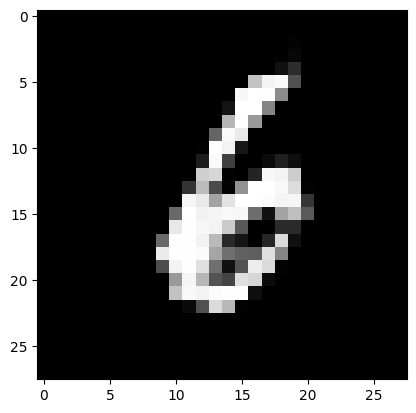

In [20]:
# Load model
generator = Generator(ngpu).to(device)
generator.load_state_dict(torch.load("./mnist-conditional-gan-model.pt", weights_only=True))

# Set the generator to evaluation mode
generator.eval()

# Generate a sample noise vector
sample_noise = torch.randn(1, nz, device=device)
sample_label = torch.tensor(6, device=device)

# Generate an image from the noise vector
X = generator(sample_noise, sample_label).detach().cpu()

# Plot the generated image
plt.imshow(X.view(image_size, image_size), cmap='gray')
plt.show()